# Analyzing Air Quality Trends in the US with EPA AQI Data
## EDS 220, Fall 2021

## Authors

- Felicia Cruz, UC Santa Barbara (feliciamcruz@bren.ucsb.edu) <br>
- Steven Cognac, UC Santa Barbara (scognac@bren.ucsb.edu) <br>
- Grace Lewin, UC Santa Barbara (glewin@bren.ucsb.edu) <br>
  

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display and Basic Visualization](#display)

[5. Use Case Examples](#usecases)

[6. Create Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
## Purpose

Air quality serves as an important indicator of human health and the environment. Under the Clean Air Act, U.S. the Environmental Protection Agency (EPA) established National Ambient Air Quality Standards (NAAQS) for five common air pollutants: ozone, particulate matter (PM2.5 and PM10), sulfur dioxide, carbon monoxide, and nitrogen dioxide. Combined, these pollutants form the U.S. Air Quality Index (AQI) for reporting air quality.

The purpose of this project is to assess how air quality in the United States has changed over time from 1980 to 2020. We will use daily Air Quality Index (AQI) data by US county and metropolitan areas for our analysis. This data is made available by the US EPA and is freely accessible. 


<a id='overview'></a> 
## Dataset Description

We use pre-generated data files in .csv format from the **US EPA** for Daily AQI by County and Daily AQI by Core-Based statistical Area (CBSA) which can be found here: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

### _Dataset Characteristics_
Both datasets include daily AQI readings for each year from January 1, 1980 through May 5, 2021.  The Daily AQI by County dataset includes observations for all 50 states plus the District of Columbia, Mexico, Virgin Islands, Canada, Guam, and Puerto Rico. The Daily AQI by CBSA is a pre-filtered subset of the county that focuses on metropolitan areas. A CBSA is an area that consists of one or more counties (or equivalents) anchored by an urban center of at least 10,000 people.  There are 699 CBSA in the EPA dataset.  We've pre-filtered ours to only 4. Both datasets were last updated May 18, 2021. Monitor location data was also used to map locations of CBSA's of interest.  This data includes latitude, longitude, and site information.  

Data of interest is AQI. The six defining parameters that contribute to AQI are Ozone, CO, NO2, SO2, PM 2.5, and PM 10.
Daily summary AQI recordings include:
1) The aggregate of all sub-daily measurements taken at the monitor.
2) The single sample value if the monitor takes a single, daily sample (e.g., there is only one sample with a 24-hour duration). In this case, the mean and max daily sample will have the same value.

To calculate AQI, the concentration of each pollutant in the air is measured and converted into a number running from zero upwards by using a standard index or scale. The calculated number for every pollutant is termed as a sub-index. The highest sub-index for any given hour is recorded as the AQI for that hour or aggregated per day. AQI runs from 0 to 500. The higher the AQI value, the greater the level of air pollution and the greater the health concern. The pollutant with the highest concentration over a 24-hour period and which corresponds to the highest sub-index is referred to as the 'Defining Parameter.'
Here is a breakdown of the different categories.
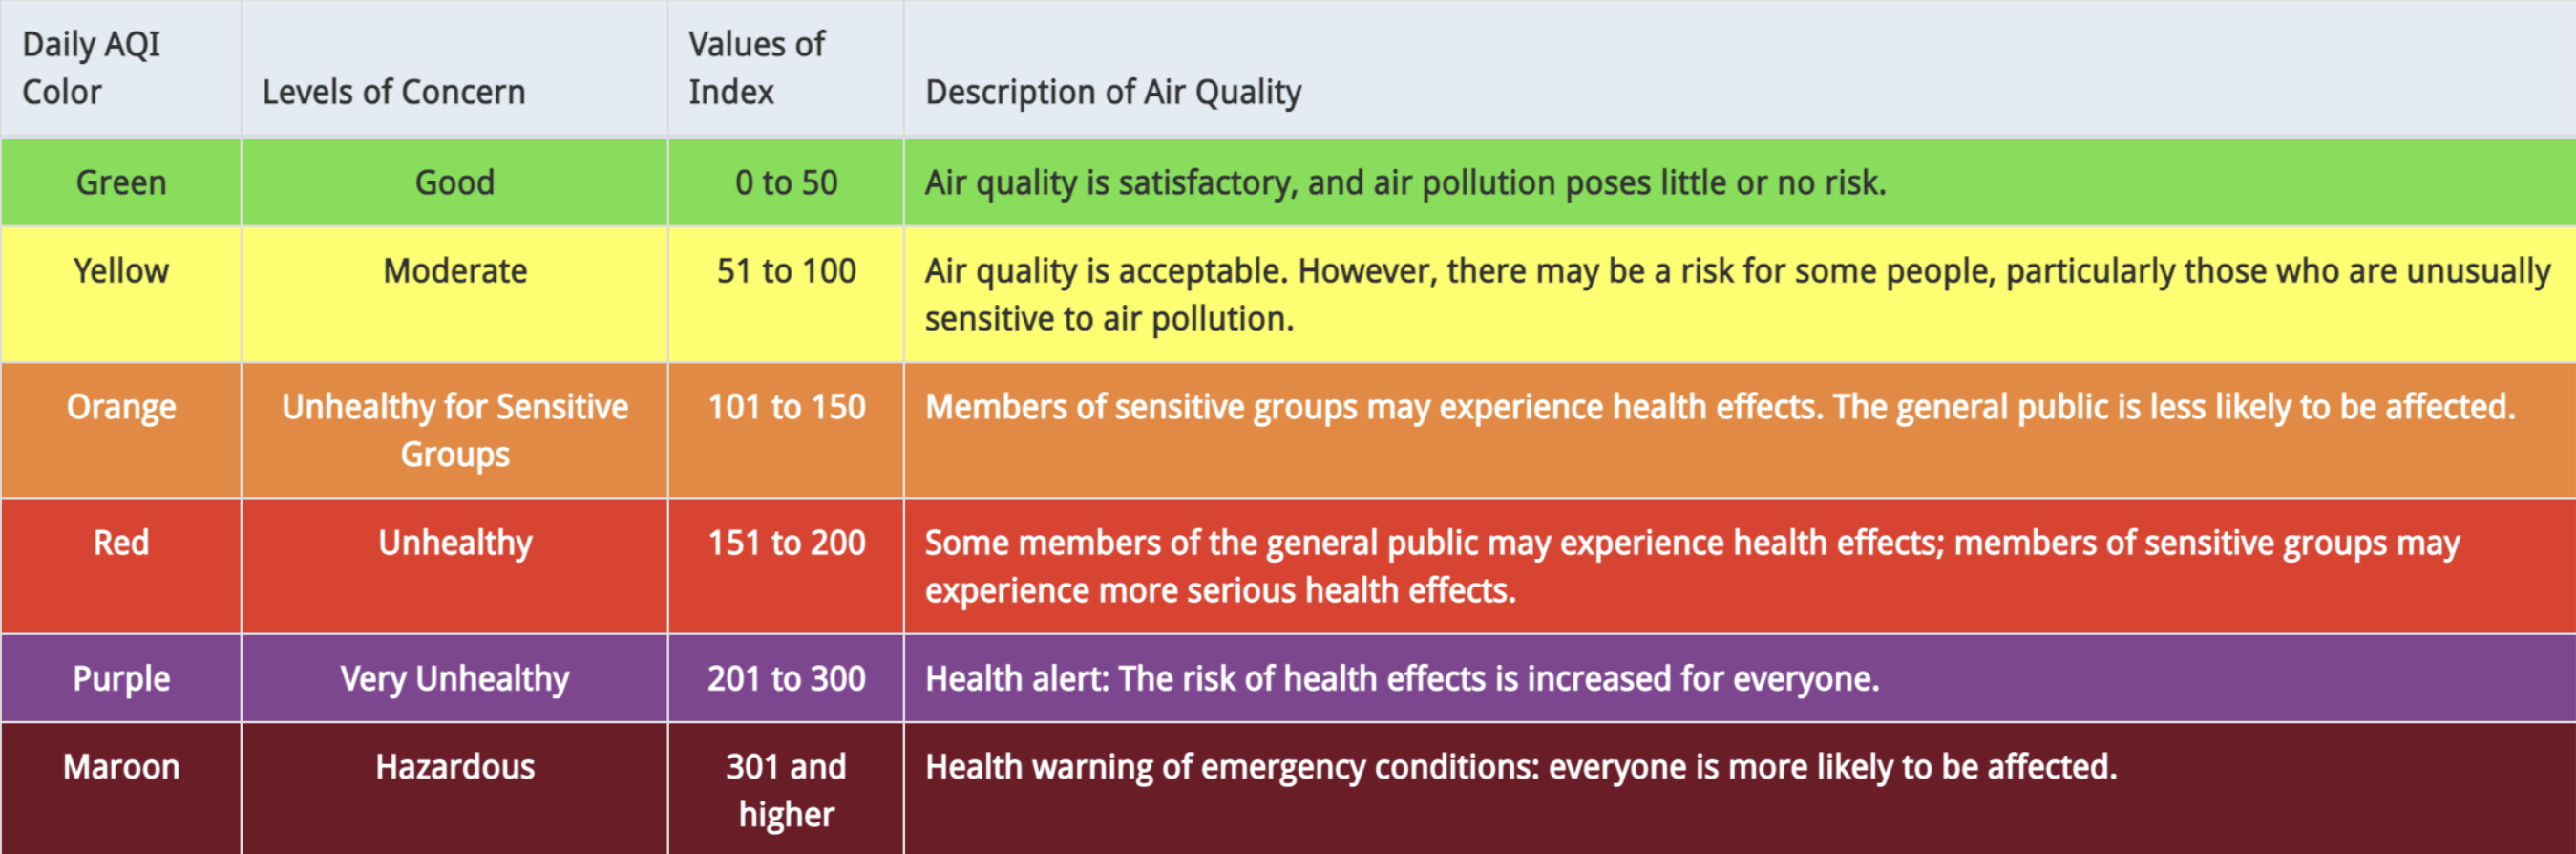

The equation to calculate sub-index values is: 
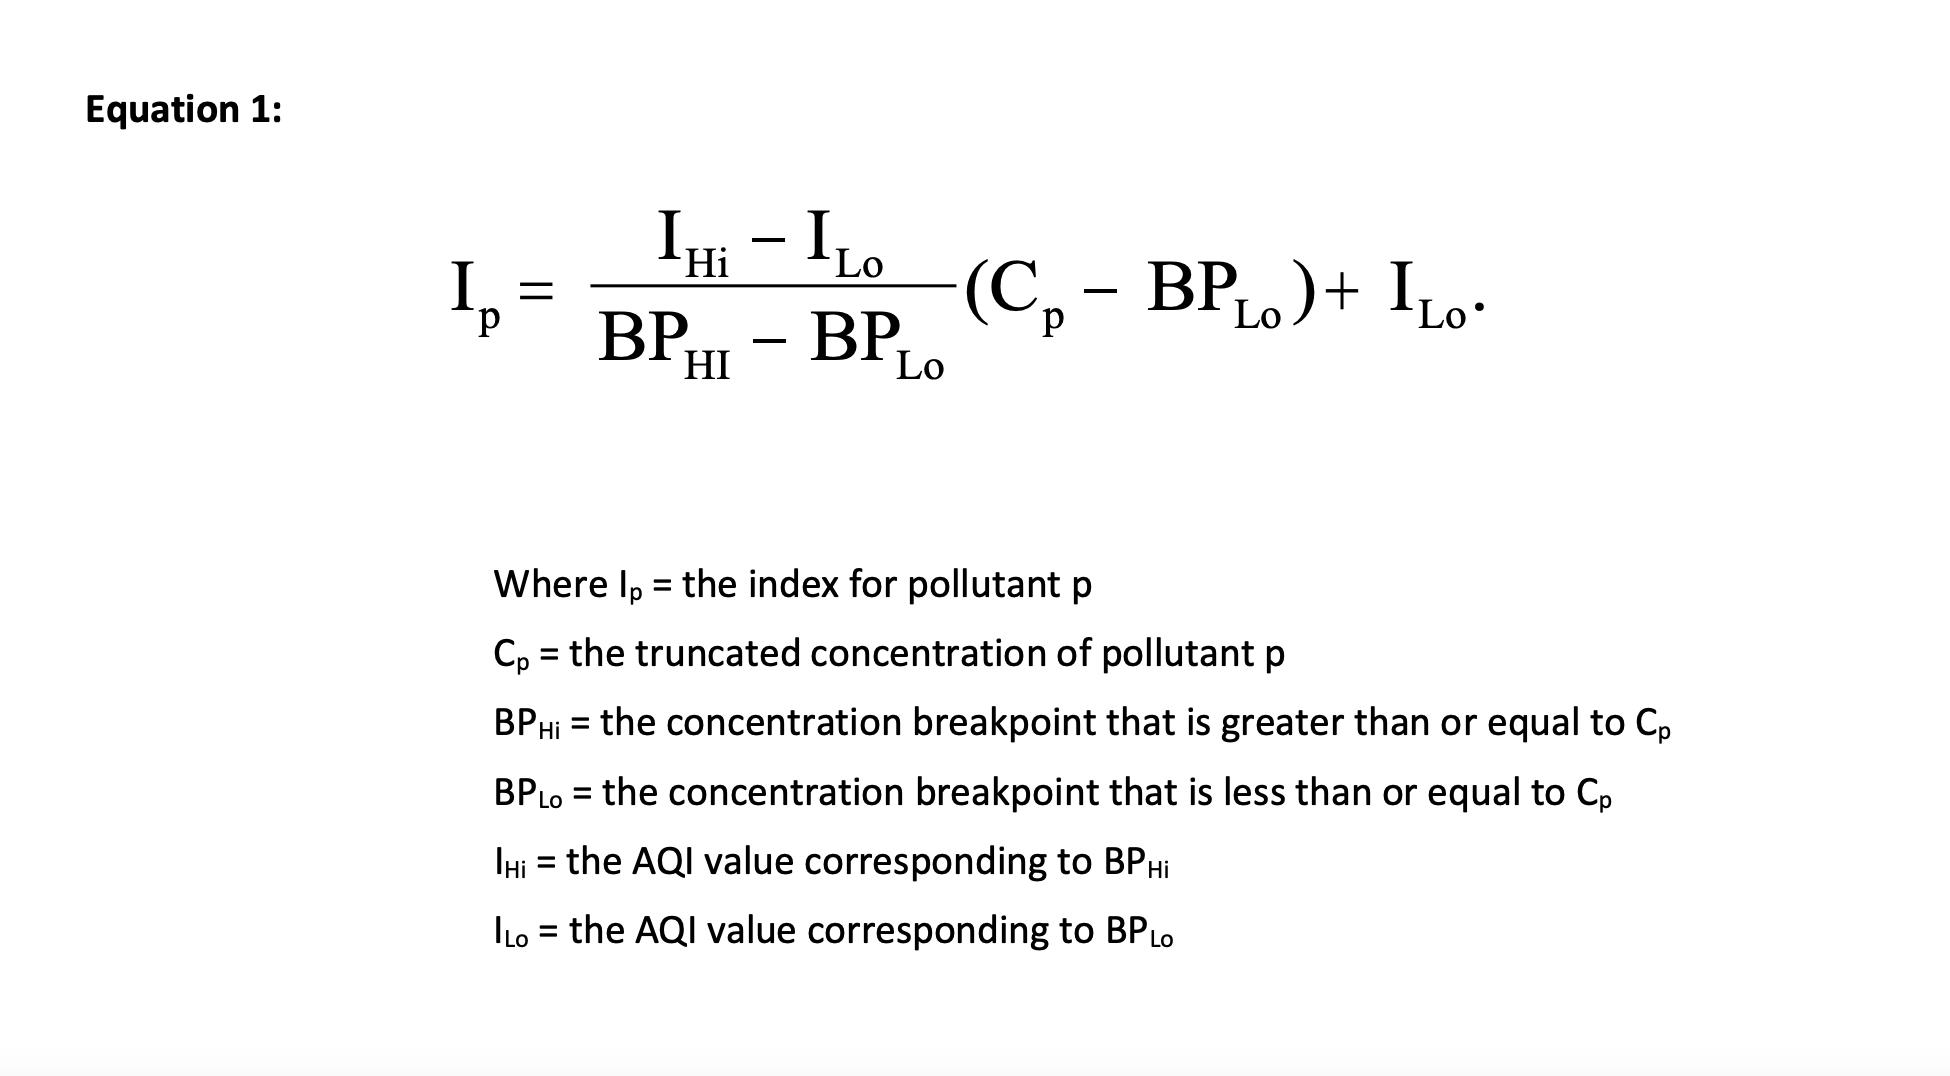




### _Data Artifacts_

- In exploring the data, not all counties included for every state. 
- Data coverage is meant to be daily averages; however, there is missing data for some days in some counties. 
- Breaks in data are not consistent.
- **Extreme Values** overview
     - US EPA AQI scale ranges from 0 to 500; however, some values are greater than 500 which indicates extremely hazardous conditions.
     - In exploring the AQI observations greater than 500, we noticed all the observations defining parameter was PM2.5 or PM10.
     - Looking at the dates and locations, this is likely due to wildfires as opposed inaccurate data.

For more information on how AQI is calculated please visit: https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf

<a id='io'></a> 
## Dataset Input/Output 

#### _HTML Parser to Download data_
Data downloaded via [beautifulsoup4](https://beautiful-soup-4.readthedocs.io/en/latest/), a HTML parser that allows you to search for specified text on any website.  Here we use it to search for download links with href (Hyptertext REFerence) anchor tags.  We created a forloop to open each url, read in the zipfiles, extract the data as a .csv file format, convert the link to a pandas dataframe and interate over every link, and merge the dataframes into a single dataframe.

#### Import Packages

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import contextily as cx

from bs4 import BeautifulSoup
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

#### Define Parse Parameters

In [ ]:
epa_site = 'https://aqs.epa.gov/aqsweb/airdata/download_files.html'
epa_link = 'https://aqs.epa.gov/aqsweb/airdata/'
county_parse = "daily_aqi_by_county_"

# not used for notebook.  Example of how you could grab different datasets on the same EPA website
cbsa_parse = "daily_aqi_by_cbsa_"
monitor_parse = "aqs_monitor"

#### Web Scrape Setup
 - Here we set up the the variables we'll use to parse [EPA data](https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI)
 - We'll use html href tags to find find downloadable data on a website
 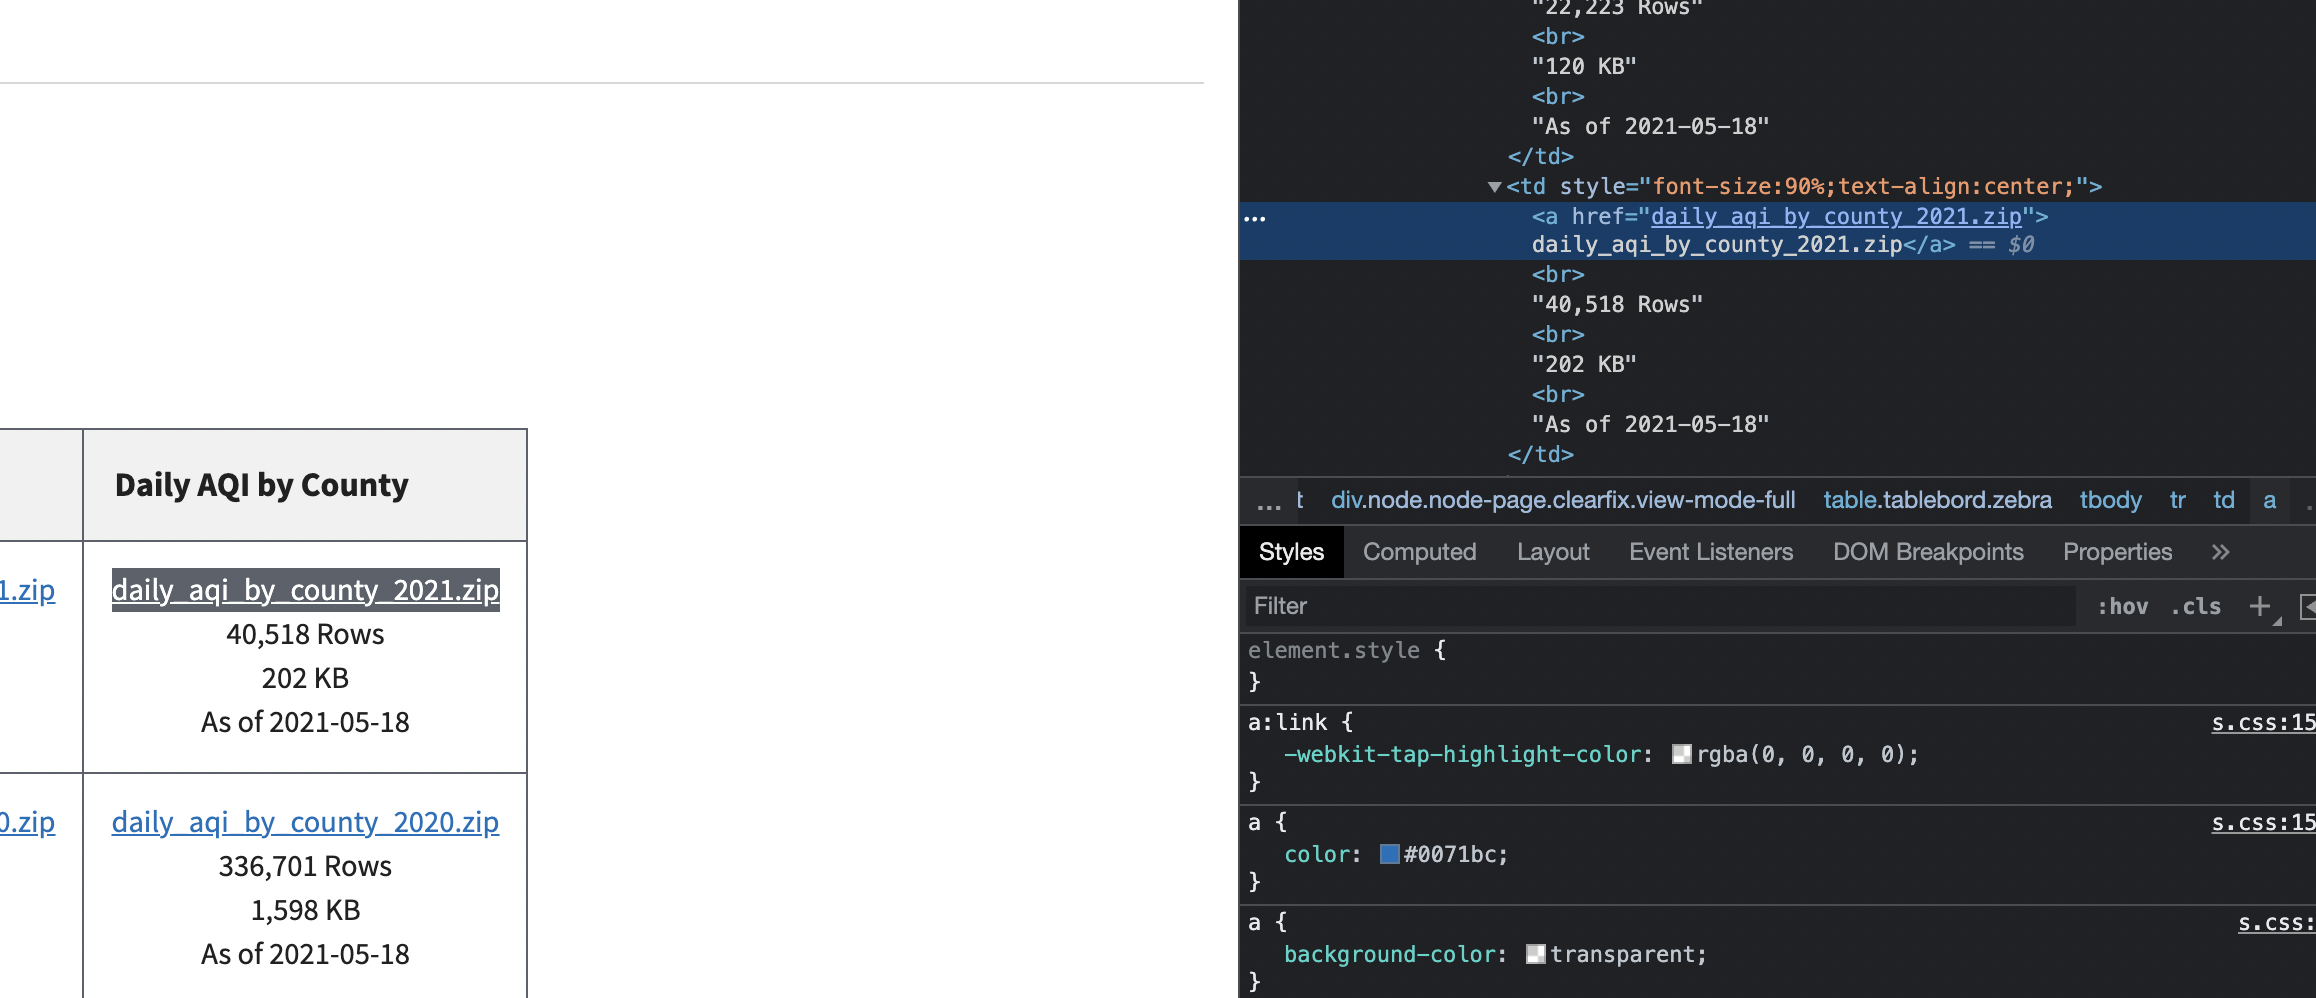

In [ ]:
# link to EPA website for pre-generated data files
html_page = requests.get(epa_site)
soup = BeautifulSoup(html_page.content, 'html.parser')

# find all a href links available on this page.
# lambda is 
file_urls = soup.findAll('a', href=lambda href: href and href.startswith(county_parse))
links = [epa_link+link.get('href') for link in file_urls]
#print(links)

#### Download, Unzip, and Compile into single df

In [ ]:
# initiating a dataframe
aqi = pd.DataFrame()

#forloop to download, unzip, and compile df
for link in links:
    
    # open url
    resp = urlopen(link)
    # read zipfile
    zipfile = ZipFile(BytesIO(resp.read()))
    # get the csv file name
    fname = zipfile.namelist()[0]
    # convert to pandas dateframe
    df = pd.read_csv(zipfile.open(fname), dtype=object)
    # close zipfile we don't need
    zipfile.close()
    
    # concatenate dataframes
    aqi = pd.concat([aqi, df], ignore_index=True, sort=False)
    
    # let you know how much it is completed.
    print(f'{fname} Completed')

#### Import datasets
For our analysis we'll focus on daily AQI by County and core bases statistical area (CBSA aka metropolitan areas) within the United States. Datasets include:
 - The county 'aqi' dataset imported via beautifulsoup4
 - Two subsets  also downloaded via beautifulsoup4
     - CBSA subset
     - Monitor locations

In [ ]:
# US daily AQI data from 1980-01-01 to 2021-05-18
cbsa_aqi = pd.read_csv('data_raw/cbsa_sites_df.csv', usecols = ['CBSA',
                                                                'CBSA Code',
                                                                'Date',
                                                                'AQI',
                                                                'Category',
                                                                'Defining Parameter','Defining Site'])

monitors = pd.read_csv('data_raw/monitors_CA_NY_UT.csv', usecols = ['Defining Site',
                                                                    'Latitude',
                                                                    'Longitude',
                                                                    'Monitor Type'])

<a id='display'></a> 
### Metadata Display and Basic Visualization

#### Metadata from EPA website

https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_content_4

In [ ]:
# let's check out our data
aqi.head(2)

In [ ]:
# first two rows of CBSAs
cbsa_aqi.head(2)

In [ ]:
# first two rows of monitors
monitors.head(2)

In [ ]:
# check out dimensions of each dataset
print(aqi.shape)
print(cbsa_aqi.shape)
print(monitors.shape)

In [ ]:
# data types of columns
print(aqi.dtypes)
print("")
print(cbsa_aqi.dtypes)
print("")
print(monitors.dtypes)

In [ ]:
# Let's check out unique metro areas in our dataset
cbsa_aqi['CBSA'].unique()

In [ ]:
# Here are our State Names.  Notice anything odd?
aqi['State Name'].unique()

#### Let's check out number of US counties

In [ ]:
# one approach
len(np.unique(aqi["county Name"].values)

In [ ]:
# per Wikipedia, there are a total of 3,243 counties in US States and territories
# a more thorough approach, there are repeating county names in different states
len(np.unique(aqi[["State Name", "county Name"]].values))

#### Plot simple figure of CBSA AQI

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(cbsa_aqi['Date'], cbsa_aqi['AQI'])

<a id='usecases'></a> 
### Part 1. AQI Trends in the US (1980-2021)

We are interested in exploring the trends in air quality from 1980-2021, specifically how each pollutant contributes to AQI readings over time. We do this by finding the number of air quality readings above 150 in each year, separated by the defining parameters for easy comparison.

We further this analysis to see if California follows the same trend as the US. Since California has extreme fire seasons and many big cities – both which negatively affect air quality – we have chosen California as a focal point to explore local patterns of air quality.

Understanding long term trends in air quality can be useful for many cases. Federal officials, such as in the EPA, as well as local government officials tasked with improving air quality must know which pollutant is most responsible for lowered air quality. By separating the data as we do below, they can evaluate which pollutant needs to be reduced the most to improve the overall air quality of the region. This analysis can also benefit health workers. By understanding the local trends in air quality, they can better understand some the health challenges their patients may be presenting with.

#### Format Data

In [ ]:
# format date as datetime
aqi['Date']=pd.to_datetime(aqi['Date'], format = '%Y-%m-%d')

# convert Category column to category data type
aqi['Category']=aqi.Category.astype('category') 

# convert object to integer
aqi['AQI'] = pd.to_numeric(aqi['AQI'])

In [ ]:
# check data types 
aqi.dtypes

In [ ]:
# subset data for readings in the unhealthy range and above (greater than 150)
aqi_unhealthy = aqi[aqi['AQI'] > 150]
aqi_unhealthy['Category'].unique()

In [ ]:
# pull out year to new column from the datetime column in aqi_unhealthy
aqi_unhealthy.loc[:, ('year')] = aqi_unhealthy.loc[:, ('Date')].dt.year

#### AQI counts for the US > 150 

In [ ]:
# subsets for each parameter for above 150 
aqi_ozone_unhealthy = aqi_unhealthy[aqi_unhealthy['Defining Parameter'] == 'Ozone']
aqi_pm25_unhealthy = aqi_unhealthy[aqi_unhealthy['Defining Parameter'] == 'PM2.5']
aqi_pm10_unhealthy = aqi_unhealthy[aqi_unhealthy['Defining Parameter'] == 'PM10']
aqi_so2_unhealthy = aqi_unhealthy[aqi_unhealthy['Defining Parameter'] == 'SO2']
aqi_co_unhealthy = aqi_unhealthy[aqi_unhealthy['Defining Parameter'] == 'CO']
aqi_no2_unhealthy = aqi_unhealthy[aqi_unhealthy['Defining Parameter'] == 'NO2']

In [ ]:
# counts for each subset 

counts_aqi_unhealthy = aqi_unhealthy.groupby('year').size().reset_index(name='count')
counts_ozone_unhealthy = aqi_ozone_unhealthy.groupby('year').size().reset_index(name='count')
counts_pm25_unhealthy = aqi_pm25_unhealthy.groupby('year').size().reset_index(name='count')
counts_pm10_unhealthy = aqi_pm10_unhealthy.groupby('year').size().reset_index(name='count')
counts_so2_unhealthy = aqi_so2_unhealthy.groupby('year').size().reset_index(name='count')
counts_co_unhealthy = aqi_co_unhealthy.groupby('year').size().reset_index(name='count')
counts_no2_unhealthy = aqi_no2_unhealthy.groupby('year').size().reset_index(name='count')

In [ ]:
# plot the number of AQI Readings above 150 by Year in the US

fig, ax = plt.subplots(figsize=(10,6), dpi = 300)

plt.plot(counts_aqi_unhealthy['year'], counts_aqi_unhealthy['count'],
         label = 'All Parameters', ls = 'dashed', color = 'black')
plt.plot(counts_ozone_unhealthy['year'], counts_ozone_unhealthy['count'],
         label = 'Ozone')
plt.plot(counts_pm25_unhealthy['year'], counts_pm25_unhealthy['count'],
         label = 'PM 2.5')
plt.plot(counts_pm10_unhealthy['year'], counts_pm10_unhealthy['count'],
         label = 'PM 10')
plt.plot(counts_so2_unhealthy['year'], counts_so2_unhealthy['count'],
         label = 'SO2')
plt.plot(counts_co_unhealthy['year'], counts_co_unhealthy['count'],
         label = 'CO')
plt.plot(counts_no2_unhealthy['year'], counts_no2_unhealthy['count'],
         label = 'NO2')

ax.legend(title = 'Defining Parameter')
plt.title('Number of AQI Readings above 150 by Year in the US')
plt.xlabel('Year')
plt.ylabel('Count')

From this line graph, we can see that air quality in the US since the 80s has generally improved. There have been some spikes, however, and in recent years it seems that PM 2.5 contributes significantly to these spikes in the number of AQI readings above 150. 

#### AQI counts for CA AQI > 150 

In [ ]:
# subset the data of AQI readings over 150 for just the state of CA
aqi_unhealthy_ca = aqi_unhealthy[aqi_unhealthy['State Name'] == 'California']

In [ ]:
# make subsets for each of the defining parameters
ozone_unhealthy_ca = aqi_unhealthy_ca[aqi_unhealthy_ca['Defining Parameter'] == 'Ozone']
pm25_unhealthy_ca = aqi_unhealthy_ca[aqi_unhealthy_ca['Defining Parameter'] == 'PM2.5']
pm10_unhealthy_ca = aqi_unhealthy_ca[aqi_unhealthy_ca['Defining Parameter'] == 'PM10']
so2_unhealthy_ca = aqi_unhealthy_ca[aqi_unhealthy_ca['Defining Parameter'] == 'SO2']
co_unhealthy_ca = aqi_unhealthy_ca[aqi_unhealthy_ca['Defining Parameter'] == 'CO']
no2_unhealthy_ca = aqi_unhealthy_ca[aqi_unhealthy_ca['Defining Parameter'] == 'NO2']

In [ ]:
# make counts of each of the parameters and save these as dataframes
counts_aqi_unhealthy_ca = aqi_unhealthy_ca.groupby('year').size().reset_index(name='count')
counts_ozone_unhealthy_ca = ozone_unhealthy_ca.groupby('year').size().reset_index(name='count')
counts_pm25_unhealthy_ca = pm25_unhealthy_ca.groupby('year').size().reset_index(name='count')
counts_pm10_unhealthy_ca = pm10_unhealthy_ca.groupby('year').size().reset_index(name='count')
counts_so2_unhealthy_ca = so2_unhealthy_ca.groupby('year').size().reset_index(name='count')
counts_co_unhealthy_ca = co_unhealthy_ca.groupby('year').size().reset_index(name='count')
counts_no2_unhealthy_ca = no2_unhealthy_ca.groupby('year').size().reset_index(name='count')

In [ ]:
# plot the number of AQI Readings above 150 by year in CA

fig, ax = plt.subplots(figsize=(10,6), dpi = 300)

plt.plot(counts_aqi_unhealthy_ca['year'], counts_aqi_unhealthy_ca['count'],
         label = 'All Parameters', ls = 'dashed', color = 'black')
plt.plot(counts_ozone_unhealthy_ca['year'], counts_ozone_unhealthy_ca['count'],
         label = 'Ozone')
plt.plot(counts_pm25_unhealthy_ca['year'], counts_pm25_unhealthy_ca['count'],
         label = 'PM 2.5')
plt.plot(counts_pm10_unhealthy_ca['year'], counts_pm10_unhealthy_ca['count'],
         label = 'PM 10')
plt.plot(counts_so2_unhealthy_ca['year'], counts_so2_unhealthy_ca['count'],
         label = 'SO2')
plt.plot(counts_co_unhealthy_ca['year'], counts_co_unhealthy_ca['count'],
         label = 'CO')
plt.plot(counts_no2_unhealthy_ca['year'], counts_no2_unhealthy_ca['count'],
         label = 'NO2')

ax.legend(title = 'Defining Parameter')
plt.title('Number of AQI Readings above 150 by Year in California')
plt.xlabel('Year')
plt.ylabel('Count')

When looking at California's AQI trends, we can see that it generally follows the same negative trend in AQI readings above 150 that the entire US does. However, it does spike in recent years. These spikes appear to be due to increases in AQI readings above 150 due to PM 2.5 as the defining parameter. 

#### AQI counts for CA AQI where PM 2.5 is the defining parameter 

In [ ]:
# subset all data for CA and PM2.5 and make new column for year
aqi_ca = aqi[aqi['State Name'] == 'California']
aqi_ca_pm25 = aqi_ca[aqi_ca['Defining Parameter'] == 'PM2.5']
aqi_ca_pm25['Year'] = pd.DatetimeIndex(aqi_ca_pm25['Date']).year
aqi_ca_pm25

In [ ]:
# plot the CA AQI Readings with PM2.5 as the Defining Parameter

fig, ax = plt.subplots(figsize = (12,8), dpi = 300)

ax.axhspan(0, 50, facecolor='green', alpha=0.3)
ax.axhspan(50, 100, facecolor='yellow', alpha=0.3)
ax.axhspan(100, 150, facecolor='orange', alpha=0.3)
ax.axhspan(150, 200, facecolor='red', alpha=0.3)
ax.axhspan(200, 300, facecolor='purple', alpha=0.3)
ax.axhspan(300, 600, facecolor='maroon', alpha=0.3)

plt.scatter(aqi_ca_pm25['Year'], aqi_ca_pm25['AQI'])
plt.ylim(0,600)
plt.title("CA AQI Readings with PM2.5 as the Defining Parameter")
plt.xlabel("Year")
plt.ylabel("AQI")

When filtering for all AQI readings above 150 with PM 2.5 as the defining parameter, we can see that there is a very clear uptick in high AQI readings. Before 2000, there were very few readings above 150, but over time readings in the "Unhealthy", "Very Unhealthy", and "Hazardous" thresholds have become much more abundant. Additionally, between 2015 and 2021 we see very high readings above 300, showing how AQI readings have worsened in addition to more abundant unhealthy readings in general. 

One possible explanation for the increased hazardous AQI readings due to PM 2.5 since 2015 is that California's wildfire season has progressively gotten worse each year. 2017 and 2020 have the highest readings. The 2017 season was the most destructive wildfire season on record at the time, with 1.2 million acres burned. The largest fire in the 2017 season was the Thomas Fire in Santa Barbara County, which was California's largest modern wildfire at the time. In 2020, 4.2 million acres were burned, more than 4% of the state's land, making 2020 the largest wildfire season recorded in California's modern history. The August Complex Fire alone burned more than 1 million acres, making it the first "gigafire" on record.  

After looking at air quality trends in the US and in California, we can see that air quality in general has seemed to get better depite some recent spikes largely due to PM 2.5. For further analysis, it would be interesting to see if high AQI readings follow seasonal patterns each year. We have speculated that the recent spikes in hazardous AQI readings due to PM 2.5 could be due to large wildfire events, but further analysis would be needed to confirm this. 

## Part 2. Rolling Mean Calculation of CBSA Areas

In this second exercise we'll compare four metropolitian area AQI's over the last couple of years.  We'll prepare a simple time series anslysis focusing in on San Francisco-Oakland-Hayward, CA; Los Angeles-Long Beach-Anaheim, CA; Salt Lake City, UT; and the New York-Newark-Jersey City, NY-NJ-PA area.  We can explore different rolling averages and see how summary statistics change.

Calculating a rolling average for smoothing is useful as a data preparation technique as it can reduce the random variation in observations and better expose the structure of the underlying causal processes. Such an analysis can help cities better understand seasonal trends in AQI and help target regional efforts where NAQQS standards are not being met.   

### Merge Datasets

In [ ]:
cbsa = cbsa_aqi.merge(monitors, on='Defining Site', 
                      how='left').drop_duplicates(ignore_index=True)

### Reorder columns

In [ ]:
cbsa_df = cbsa[['Date','AQI','Defining Parameter','Category','CBSA','Longitude','Latitude']]

#### Set Index column as "Date" column

In [ ]:
cbsa_df.set_index('Date', inplace=True)

### Calculate rolling mean

In [ ]:
cbsa_rolling = cbsa_df.copy()

# time window to calculate rolling average
window = 60

cbsa_rolling['rolling_AQI_mean'] = cbsa_df['AQI'].rolling(window = window).mean()

In [ ]:
cbsa_rolling.head(2)

In [ ]:
cbsa_rolling['rolling_AQI_mean'].describe()

In [ ]:
cbsa_rolling['AQI'].describe()

### Plot Data

In [ ]:
# figure set up
fig, ax = plt.subplots(figsize=(20, 10))

# add data
cbsa_rolling.groupby('CBSA')['rolling_AQI_mean'].plot(ax=ax,legend='False')
#cbsa_rolling.groupby('CBSA')['AQI'].plot(ax=ax,legend='False')

# set plot labels and axix
plt.title('1980-2021 Daily AQI in LAX, NYC, SLC, and SF Metropolitan Areas', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('AQI', fontsize=14)
plt.xlim([np.datetime64('2018-01-01'), np.datetime64('2021-03-20')])
plt.ylim(0,250)
plt.axvspan(np.datetime64('2020-03-01'), np.datetime64('2021-03-01'), alpha=0.4)

ax.axhspan(0, 50, facecolor='green', alpha=0.3)
ax.axhspan(50, 100, facecolor='yellow', alpha=0.3)
ax.axhspan(100, 150, facecolor='orange', alpha=0.3)
ax.axhspan(150, 200, facecolor='red', alpha=0.3)
ax.axhspan(200, 300, facecolor='purple', alpha=0.3)
ax.axhspan(300, 600, facecolor='maroon', alpha=0.3)

## Part 3. Plot CBSA Create geodataframe 

In [ ]:
# convert to geodataframe
geoms=gpd.points_from_xy(cbsa_df['Longitude'], cbsa_df['Latitude'], crs='EPSG:4326')

cbsa_gdf=gpd.GeoDataFrame(cbsa_df,geometry=geoms)

### Subset AQI datasets

In [ ]:
lax = cbsa_gdf[cbsa_gdf['CBSA'].str.contains("Los Angeles")]
sf = cbsa_gdf[cbsa_gdf['CBSA'].str.contains("San Francisco")]
slc = cbsa_gdf[cbsa_gdf['CBSA'].str.contains("Salt Lake")]
nyc = cbsa_gdf[cbsa_gdf['CBSA'].str.contains("New York")]

In [ ]:
lax.dtypes

### Location of Monitoring Stations

In [ ]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax1.set_title('San Francisco-Oakland-Hayward, CA')
ax2.set_title('Los Angeles-Long Beach-Anaheim, CA')
ax3.set_title('Salt Lake City, UT')
ax4.set_title('New York-Newark-Jersey City, NY-NJ-PA')

sf['geometry'].plot(ax=ax1)
lax['geometry'].plot(ax=ax2)
slc['geometry'].plot(ax=ax3)
nyc['geometry'].plot(ax=ax4)

cx.add_basemap(ax1, crs=4326)
cx.add_basemap(ax2, crs=4326)
cx.add_basemap(ax3, crs=4326)
cx.add_basemap(ax4, crs=4326)

for ax in (ax1,ax2,ax3,ax4):
    ax.axis('off')

<a id='binder'></a> 
### Create Binder Environment


Binder environment created for this tutorial.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/aqi-science/notebook/main)



<a id='references'></a> 
### References

1. Air Quality Index (AQI) calculations: https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
2. AQI description: https://www.airnow.gov/aqi/aqi-basics/
3. Particulte Matter: https://www.epa.gov/pm-pollution/particulate-matter-pm-basics
4. 2017 Fire Season: https://www.fire.ca.gov/incidents/2017/
5. 2020 Fire Season: https://www.fire.ca.gov/incidents/2020/
6. Pre-generated Data Files: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
7. EPA Air Quality System Databse: https://aqs.epa.gov/aqsweb/documents/about_aqs_data.html
8. AQI Metadata: https://aqs.epa.gov/aqsweb/documents/data_api.html#variables
9. beautifulsoup4: https://beautiful-soup-4.readthedocs.io/en/latest/
 